<a href="https://colab.research.google.com/github/SriHarini2405/Ideathon-/blob/main/mac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt


In [3]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                       download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                      download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)




100%|██████████| 9.91M/9.91M [00:00<00:00, 58.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.69MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.03MB/s]


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, trunc_bits=0, mode="exact"):
        super(SimpleCNN, self).__init__()
        self.trunc_bits = trunc_bits
        self.mode = mode

        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)

        self.fc1 = nn.Linear(64*22*22, 10)

    # ----- Fixed-Point Truncation -----
    def truncate(self, x):
        if self.trunc_bits == 0:
            return x

        scale_factor = 1024.0   # Q10 fixed-point simulation

        x_fixed = torch.round(x * scale_factor)
        trunc_scale = 2 ** self.trunc_bits

        x_trunc = torch.floor(x_fixed / trunc_scale) * trunc_scale

        return x_trunc / scale_factor

    def forward(self, x):

        # Conv1 (always exact)
        x = F.relu(self.conv1(x))

        # Conv2
        x = F.relu(self.conv2(x))
        if self.mode in ["approx", "adaptive"]:
            x = self.truncate(x)

        # Conv3
        x = F.relu(self.conv3(x))
        if self.mode in ["approx", "adaptive"]:
            x = self.truncate(x)

        x = torch.flatten(x, 1)

        # FC
        x = self.fc1(x)
        if self.mode in ["approx", "adaptive"]:
            x = self.truncate(x)

        return x






In [5]:
def train_model(model, epochs=3):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    model.train()

    for epoch in range(epochs):
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    return model



In [6]:
def test_model(model):
    correct = 0
    total = 0

    model.eval()

    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total



In [7]:
model_exact = SimpleCNN(trunc_bits=0, mode="exact")
model_exact = train_model(model_exact)

acc_exact = test_model(model_exact)
print("Exact Accuracy:", acc_exact)


Exact Accuracy: 98.68


In [14]:
trunc_bits = 8


In [18]:
model_adaptive = SimpleCNN(trunc_bits=8, mode="adaptive")
model_adaptive.load_state_dict(model_exact.state_dict())

acc_adaptive = test_model(model_adaptive)
print("Adaptive Accuracy:", acc_adaptive)


Adaptive Accuracy: 97.88


In [21]:
model_approx = SimpleCNN(trunc_bits=9, mode="approx")
model_approx.load_state_dict(model_exact.state_dict())
print("All Approx:", test_model(model_approx))


All Approx: 89.29


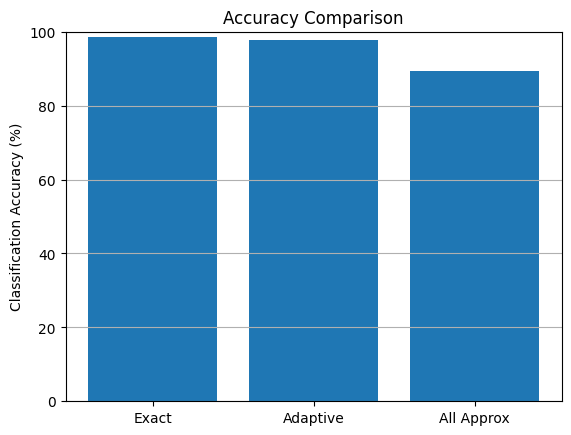

In [24]:
acc_exact = test_model(model_exact)
acc_adaptive = test_model(model_adaptive)
acc_approx = test_model(model_approx)

import matplotlib.pyplot as plt

labels = ["Exact", "Adaptive", "All Approx"]
values = [acc_exact, acc_adaptive, acc_approx]

plt.figure()
plt.bar(labels, values)
plt.ylabel("Classification Accuracy (%)")
plt.title("Accuracy Comparison")
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()



In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


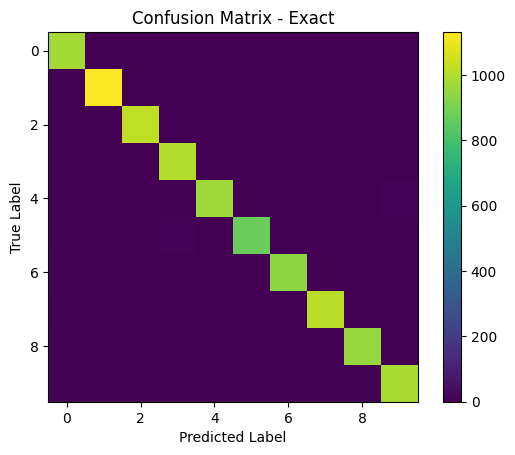

In [26]:
all_preds = []
all_labels = []

model_exact.eval()

with torch.no_grad():
    for images, labels in testloader:
        outputs = model_exact(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

cm_exact = confusion_matrix(all_labels, all_preds)

plt.figure()
plt.imshow(cm_exact)
plt.title("Confusion Matrix - Exact")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()
plt.show()


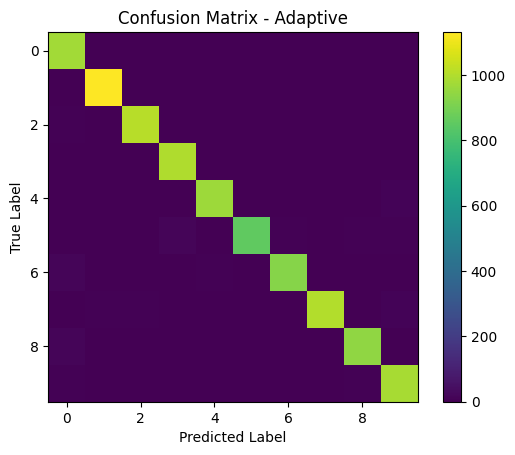

In [27]:
all_preds = []
all_labels = []

model_adaptive.eval()

with torch.no_grad():
    for images, labels in testloader:
        outputs = model_adaptive(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

cm_adaptive = confusion_matrix(all_labels, all_preds)

plt.figure()
plt.imshow(cm_adaptive)
plt.title("Confusion Matrix - Adaptive")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()
plt.show()


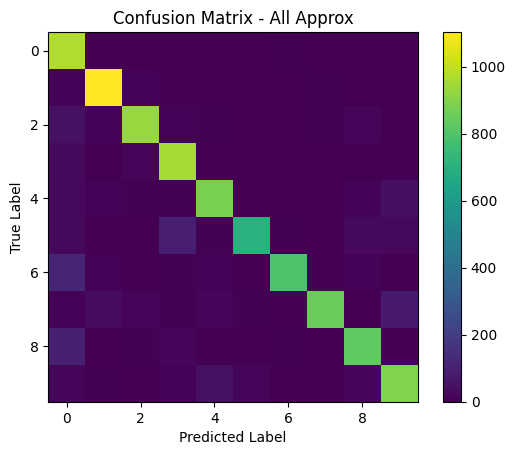

In [28]:
all_preds = []
all_labels = []

model_approx.eval()

with torch.no_grad():
    for images, labels in testloader:
        outputs = model_approx(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

cm_approx = confusion_matrix(all_labels, all_preds)

plt.figure()
plt.imshow(cm_approx)
plt.title("Confusion Matrix - All Approx")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()
plt.show()


In [29]:
from sklearn.metrics import f1_score


In [30]:
all_preds = []
all_labels = []

model_adaptive.eval()

with torch.no_grad():
    for images, labels in testloader:
        outputs = model_adaptive(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())


In [31]:
f1_macro = f1_score(all_labels, all_preds, average='macro')
f1_micro = f1_score(all_labels, all_preds, average='micro')
f1_weighted = f1_score(all_labels, all_preds, average='weighted')

print("F1 Score (Macro):", f1_macro)
print("F1 Score (Micro):", f1_micro)
print("F1 Score (Weighted):", f1_weighted)


F1 Score (Macro): 0.9785179179858389
F1 Score (Micro): 0.9788
F1 Score (Weighted): 0.9788029734897645


In [32]:
def compute_f1(model, name):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')

    print(f"{name} - Macro F1: {f1_macro:.4f}")
    print(f"{name} - Weighted F1: {f1_weighted:.4f}")
    print("--------------------------------------------------")


compute_f1(model_exact, "Exact MAC")
compute_f1(model_adaptive, "Adaptive MAC")
compute_f1(model_approx, "All Approx MAC")


Exact MAC - Macro F1: 0.9866
Exact MAC - Weighted F1: 0.9868
--------------------------------------------------
Adaptive MAC - Macro F1: 0.9785
Adaptive MAC - Weighted F1: 0.9788
--------------------------------------------------
All Approx MAC - Macro F1: 0.8925
All Approx MAC - Weighted F1: 0.8938
--------------------------------------------------
